# Practical work 6 : Harris Corner Detector

The goal of this pratical work is to implement the Harris-Stephen's corners detector (C. Harris and M. Stephens. A combined corner and edge detector. In Proc. Fourth Alvey Vision Conference, pages 147–151, 1988).

Recall the Harris detector computes a map of corners from an image $I$:
$$
R(x,y) = \operatorname{det}(M) - k (\operatorname{trace}(M))^2, (x,y) \text{pixels}
$$
with $k\in[0.04, 0.06]$. $M$ is the auto-correlation of image $I$:
$$
M=\begin{pmatrix}
\sum_{x,y \in W} w(x,y)I_x^2 &
\sum_{x,y \in W} w(x,y)I_xI_y \\
\sum_{x,y \in W} w(x,y)I_xI_y &
\sum_{x,y \in W} w(x,y)I_y^2 
\end{pmatrix}
=\begin{pmatrix}
A & B \\ C & D
\end{pmatrix}
$$
with $w(x,y)=\frac1{2\pi \sigma^2}e^{\frac{(x-x_c)^2 + (y-y_c)^2}{2\sigma^2}}$ a Gaussian mask centered on the window $W$. Partial derivatives $I_x$ and $I_y$ are estimated by one of the following kernels :
- Gradient:  $G_x = \begin{pmatrix} 0 & 0 & 0\\ 1 & 0 &-1 \\ 0 & 0 & 0 \end{pmatrix}$,
 $G_y = G_x^T$
- Prewitt: $G_x = \begin{pmatrix} 1 & 0 & -1\\ 1 & 0 &-1 \\ 1 & 0 & -1 \end{pmatrix}$,
 $G_y = G_x^T$
- Sobel: $G_x = \begin{pmatrix} 1 & 0 & -1\\ 2 & 0 &-2 \\ 1 & 0 & -1 \end{pmatrix}$,
 $G_y = G_x^T$
 


In [19]:
# Load useful libraries
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import scipy.signal

# Useful functions 
def gaussianKernel(sigma):
    """ double -> Array
        return a gaussian kernel of standard deviation sigma
    """
    n2 = int(np.ceil(3*sigma))
    x,y = np.meshgrid(np.arange(-n2,n2+1),np.arange(-n2,n2+1))
    kern = np.exp(-(x**2+y**2)/(2*sigma*sigma))
    return  kern/kern.sum()

def imshow(I, title=None, size=500, axis=False):
    """ display an image, with title, size, and axis """
    plt.figure(figsize=(size//80, size//80))
    plt.gray()
    plt.imshow(I)
    if not axis: plt.axis('off')
    if title: plt.title(title)
    plt.show()

## Exercise 1: Harris response calculation

1) Write a function `computeR(I, scale, kappa)` that returns the Harris response $R$ from an image $I$ and a scale $scale$. You will use 5 steps:
- Computation of the directionnal derivate $I_x$ and $I_y$. Use the Sobel kernel.
- Computation of the products $I_x^2$, $I_y^2$, $I_x.I_y$.
- Computation of the convolution of $I_x^2$, $I_y^2$ and $I_x.I_y$ by a gaussian kernel of size N (use given function `gaussianKernel()`)
- Computation of $\operatorname{det}(M(x,y))$ and $\operatorname{trace}(M(x,y))$ for each pixel
- Computation of $R(x,y) = \operatorname{det}(M(x,y)) - k.(\operatorname{trace}(M(x,y)))^2$. You can use $k = 0.04$.

 You can compute the convolutions by using the ```scipy.signal.convolve2d``` function. 


In [20]:
def computeR(image,scale,kappa):
    """ Array[n, m]*float*float->Array[n, m]
    """
    # First step
    Sx = np.array([(1, 0, -1), (2, 0, -2), (1, 0, -1)])
    Sy = np.array([(1, 2, 1), (0, 0, 0), (-1, -2, -1)])
    Ix = scipy.signal.convolve2d(image, Sx, "same")
    Iy = scipy.signal.convolve2d(image, Sy, "same")
    
    # Second step
    Ix2 = Ix * Ix
    Iy2 = Iy * Iy
    Ixy = Ix * Iy
    
    # Third step
    gaussian = gaussianKernel(sigma)
    A = scipy.signal.convolve2d(Ix2, gaussian, 'same')
    B = scipy.signal.convolve2d(Iy2, gaussian, 'same')
    C = scipy.signal.convolve2d(Ixy, gaussian, 'same')
    
    # Fourth step
    det = np.zeros((256, 256))
    trace = np.zeros((256, 256))
    det = A*B - C**2
    trace = A + B
    
    # Fifth step
    R = np.zeros((256, 256))
    R = det - 0.04 * (trace**2)
    
    return R

2) Write a script that displays the Harris response for the image ```img/house2.png``` along with the original image. Use a gaussian window of size $W=15$ pixels.

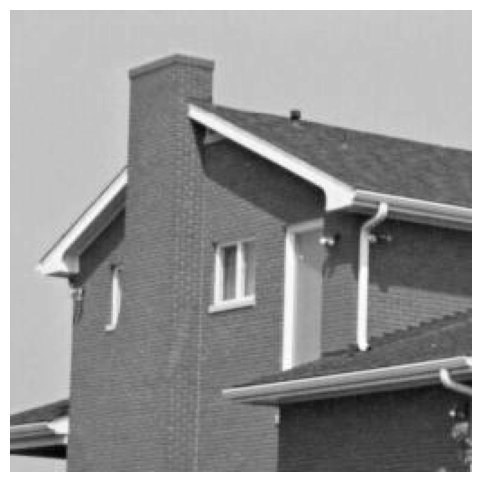

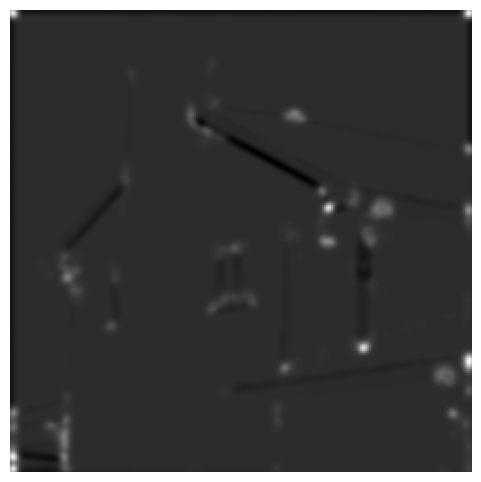

In [80]:
# Original image
house2 = np.array(Image.open('img/house2.png'))
imshow(house2)

w = n = 15 # widnow
sigma = (15-1) / 6 # sigma
n = 2 * np.ceil(3*sigma) + 1 # n

# Harris response
house2_HR = computeR(house2, 2.33, 0.04)
imshow(house2_HR)

3) Write in a few lines an interpretation of the results, explaining how the Harris response allows to detect and discriminate homogeneous areas, edges and corners.

The Harris response allows us to discriminate between homogeneous areas, edges, and corners within an image, as we can see above.

In regions of the image that are uniform or homogeneous, the Harris response is generally low. This is because there are no significant variations in intensity or color in these areas.

Along edges in the image, the Harris response is moderate. Edges are characterized by a significant change in intensity or color, resulting in one eigenvalue of the M matrix being significantly larger than the other.

The Harris response is the highest at corner points. Corners exhibit strong intensity variations in multiple directions. That is why corners are easily distinguishable as we can see in the above image.

## Exercise 2 : Harris corner detector
From the Harris response calculated at exercise 1, we will write all the functions needed for the Harris detector. Write the following functions: 

1) A function `thresholdR(R, thres)` that calculates and returns the binary thresholding $R_b$ of the response $R$ according to the threshold $thres$

In [23]:
def thresholdR(R, thres):
    """ Array[n, m] * float -> Array[n, m]
    """
    return(np.where(R < thres, 0, 1))

2) A function `Rnms(R, Rbin)` that performs a non-maximum supression from the response $R$ and the binarized response $R_{bin}$. It returns the image $R_{locmax}$ (same size as $R$) =1 where $R_{bin}=1$ and the pixel has a greater value $R$ than its 8 nearest neighbors.

**Bonus**: Write a faster version of the script using Numpy function `np.roll()`.

In [41]:
def Rnms(R, Rbin):
    """ Array[n, m] -> Array[n, m] 
    """
    left = np.greater(R, np.roll(R, 1, axis = 1))
    right = np.greater(R, np.roll(R, -1, axis = 1))
    up = np.greater(R, np.roll(R, 1, axis = 0))
    down = np.greater(R, np.roll(R, -1, axis = 0))
    Rlocmax = np.zeros(R.shape)
    for x in range(R.shape[0]):
        for y in range(R.shape[1]):
            if(left[x,y] and right[x,y] and up[x,y] and down[x,y] and Rbin[x,y] == 1):
                Rlocmax[x,y] = 1
    return(Rlocmax)

3) Write a function ``cornerDetector(image, scale, kappa, thresh)`` that returns an array of the same size as the image. The array takes two values: 1 where a corner is detected and 0 elsewhere.

In [43]:
def cornerDetector(image, sigma, kappa, thres):
    """ Array[n, m]*float*float*float -> Array[n, m]
    """
    image_HR = computeR(image, sigma, kappa)
    Rbin = thresholdR(image_HR, thres)
    image_Rnms = Rnms(image_HR, Rbin)
    return image_Rnms

4 ) Display the detected corners on the original image for the image ```img/house2.png```. Each detected corner will be displayed as a small red disk. You can use the functions ```np.nonzero()``` and ```plt.scatter()``` to that purpose.

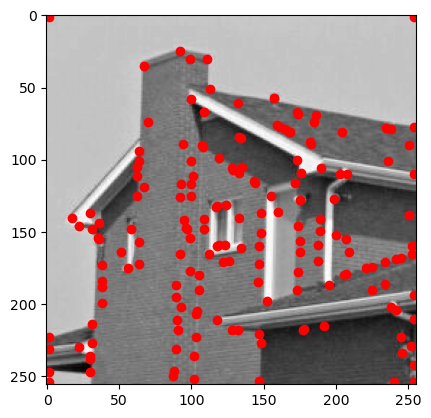

In [67]:
# Display corner function
def displayCorner(image, sigma, kappa, thres):
    corner_image = cornerDetector(image, sigma, kappa, thres)
    nonzero = np.nonzero(corner_image)

    for x in range(0, len(nonzero), 2):
        plt.scatter(nonzero[x+1], nonzero[x], c = "r")
        
    plt.imshow(image)
    plt.show()

# Display the detected corners. Number varies when changing the thres variable.
displayCorner(house2, 2.33, 0.04, 10**6)


5) Evaluate the performances of the corner detector. Try to find good values for Sigma and Threshold.

The detector in general works pretty well. It identifies most of the corners it is supposed to find. It detects, however, some more corners like in the rooftop. It also detectes the shadow of the rooftop on the wall of the house, but this makes sense, since the density/color is different, making it look like an edge. 

A good value for the threshold varies between 10^6 and 10^7, depending on what we consider to be a corner. A sigma value that works fine is 2.33.

Below we can see some more images with other values of sigma and threshold.

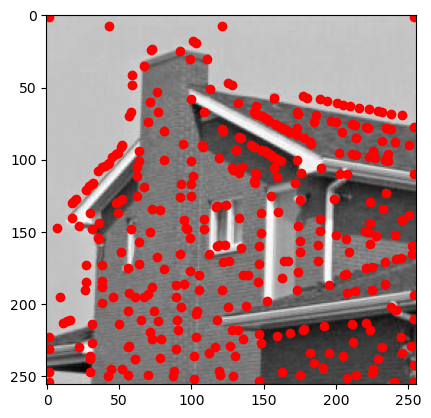

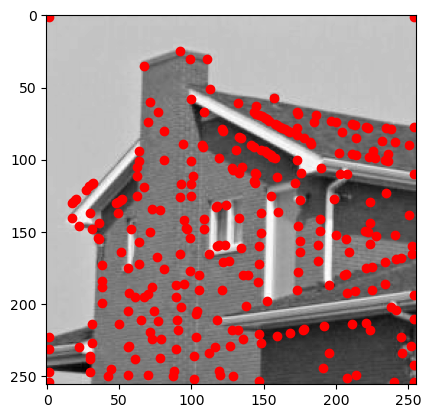

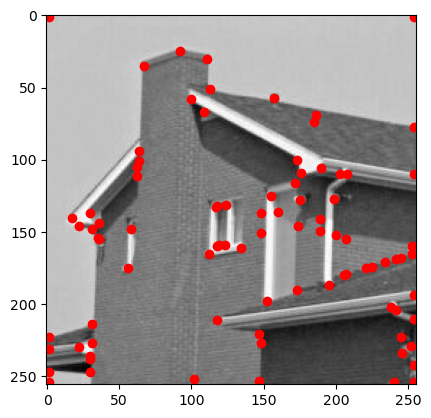

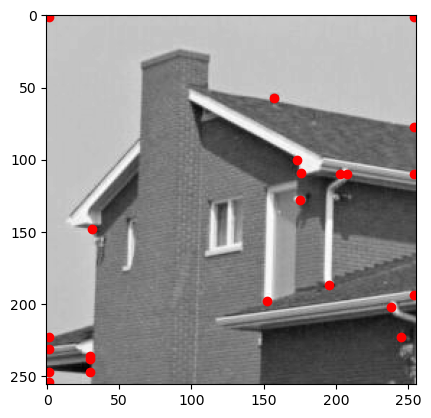

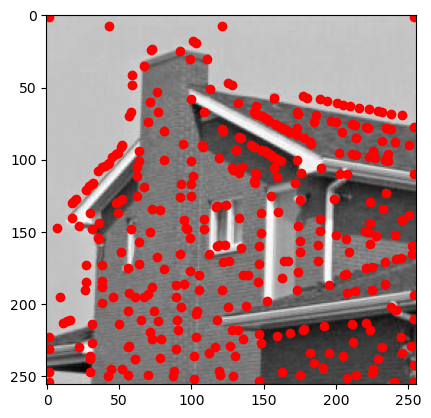

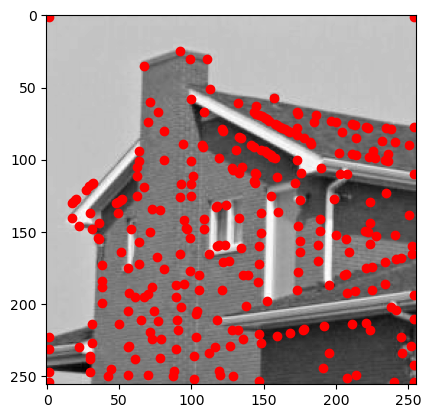

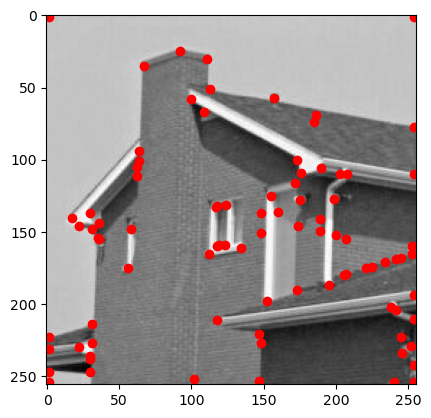

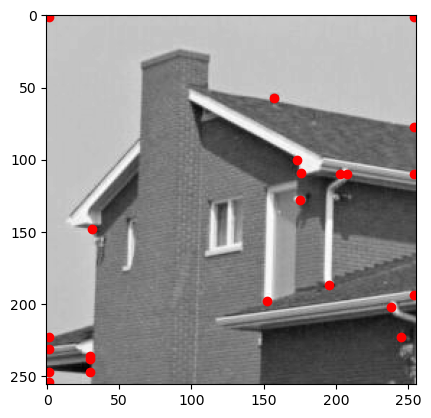

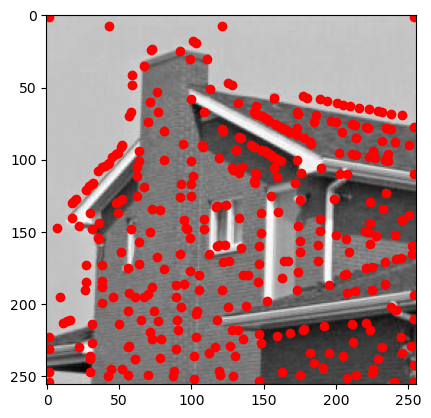

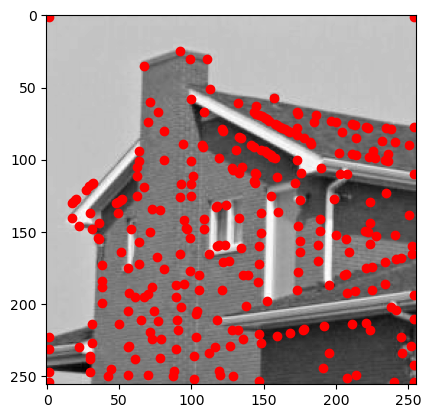

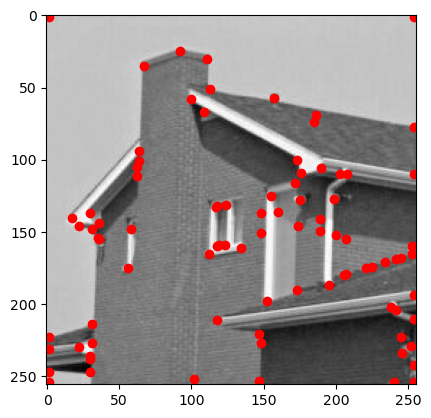

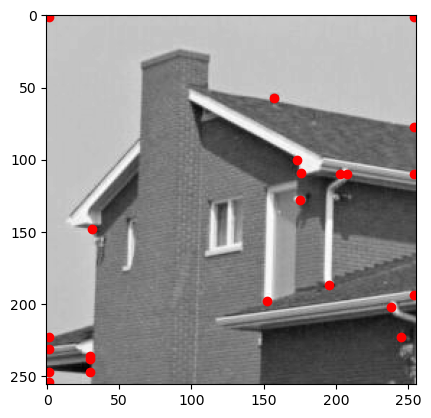

In [69]:
displayCorner(house2, 1, 0.04, 10**3)
displayCorner(house2, 1, 0.04, 10**5)
displayCorner(house2, 1, 0.04, 10**7)
displayCorner(house2, 1, 0.04, 10**9)

displayCorner(house2, 3, 0.04, 10**3)
displayCorner(house2, 3, 0.04, 10**5)
displayCorner(house2, 3, 0.04, 10**7)
displayCorner(house2, 3, 0.04, 10**9)

displayCorner(house2, 10, 0.04, 10**3)
displayCorner(house2, 10, 0.04, 10**5)
displayCorner(house2, 10, 0.04, 10**7)
displayCorner(house2, 10, 0.04, 10**9)

## Exercise 3 : Properties of Harris corner detector

The goal of this exercice is to study some invariance properties of Harris detector.

1) Write a script that detects the corners on the images ```img/toyHorse1.png``` and ```img/toyHorse2.png``` with a scale of 15 and appropriate threshold value. Display the detected corners on the images.

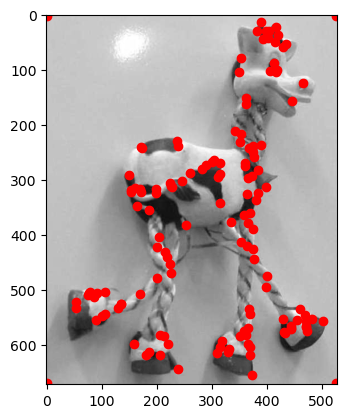

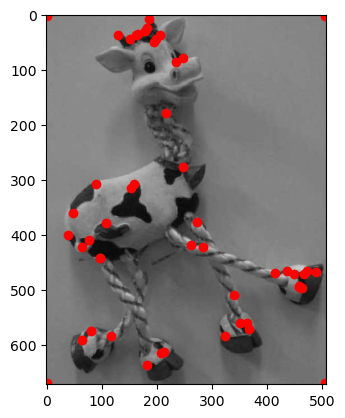

In [81]:
toyhorse1 = np.array(Image.open('img/toyHorse1.png'))
toyhorse2 = np.array(Image.open('img/toyHorse2.png'))
displayCorner(toyhorse1, 2.33, 0.04, 10**8)
displayCorner(toyhorse2, 2.33, 0.04, 10**8)

2) What are the dynamic ranges of these two images ?

In [78]:
# Calculate dynamic ranges
print(np.amax(toyhorse1) - np.amin(toyhorse1))
print(np.amax(toyhorse2) - np.amin(toyhorse2))

254
253


For the toyhorse1 image the dynamic range is 254, while for the toyhorse2 it is 253.

3) What are the transformations beetween the two images ?

First of all, the second photo is rotated in the 2d plane, so the toyhorse2 is facind a bit upwards compared to the first one.
Also, in the 3d plane there is a small rotation as well, since we can see more of the horse's face.
Finally, the second image is a bit darker than the first one, thus having less contrast.

4) Using a fixed threshold, is the detection invariant to rotation ? To affine transformation of brightness ?

When rotating the image, we can see that the detection adapts, and detects the edges and the corners on the horse, e.g. on its legs.
However detection is not invariant, since for the same threshold we have many more dots in the first image than in the second. This is mostly due to the different levels of brightness between the two images.